# Signal2Signal with RNN

Import the required packages :

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In this notebook we train a Recurrent Neural Network to predict a signal to signal correspondance. More precisely, we want to reproduce the following sequence:

$$(f_1(t_i),f_2(t_i),f_3(t_i))\to(f_1(t_i)-f_2(t_i)-f_3(t_i))$$

where $f_i$ are given functions.

The functions are given by:

In [118]:
def f1(t):
   "f1 function"
   ret = torch.sin(t)
   return ret
def f2(t):
   "f2 function"
   ret = torch.cos(t)
   return ret
def f3(t):
   "f3 function"
   ret = t
   return ret
def f4(t):
   "f4 function"
   ret = f1(t) - f2(t) - f3(t) 
   return ret

They look like:

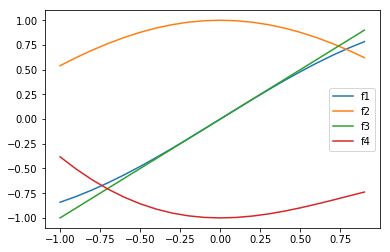

In [119]:
dt = 0.1
t = torch.arange(-1.0, 1.0, dt)
fig, ax = plt.subplots()
ax.plot(t.numpy(),f1(t).numpy(),"-", label="f1")
ax.plot(t.numpy(),f2(t).numpy(), "-", label="f2")
ax.plot(t.numpy(),f3(t).numpy(), "-", label="f3")
ax.plot(t.numpy(),f4(t).numpy(), "-", label="f4")
ax.legend();

## Pre-training

### Construct Data

We will cut the data in sequences of size $\text{seq$\_$len}$ data points. The input and target sequences are:

$$\left(
\begin{array}{cccc}
 f_1(t_{i}) & f_2(t_{i}) & f_3(t_{i})\\
 \vdots  & \vdots  & \vdots  \\
 f_1(t_{i+\text{seq$\_$len}}) & f_2(t_{i+\text{seq$\_$len}}) & f_3(t_{i+\text{seq$\_$len}})
\end{array}
\right)
\to
\left(
\begin{array}{cccc}
f_4(t_{i}) \\
\vdots  \\
f_4(t_{i+\text{seq$\_$len}})
\end{array}
\right)
$$

We create the Dataset object to manage the data. The method ``__getitem__`` returns a trianing example of the form:

$$\left(
\begin{array}{cccc}
 x_1^1 & x_1^2 & \ldots & x_1^{\text{input$\_$size$\_$x}} \\
 \vdots  & \vdots  & \ldots  & \vdots  \\
 x_{\text{seq$\_$len}}^1 & x_{\text{seq$\_$len}}^2 & \ldots & x_{\text{seq$\_$len}}^{\text{input$\_$size$\_$x}} \\
\end{array}
\right)
\to
\left(
\begin{array}{cccc}
 y_1^1 & y_1^2 & \ldots & y_1^{\text{input$\_$size$\_$y}} \\
 \vdots  & \vdots  & \ldots  & \vdots  \\
 y_{\text{seq$\_$len}}^1 & y_{\text{seq$\_$len}}^2 & \ldots & y_{\text{seq$\_$len}}^{\text{input$\_$size$\_$y}} \\
\end{array}
\right)
$$

In [120]:
class Sig2SigDataset(Dataset):
    """ Sig2Sig dataset."""
    
    def __init__(self, h_size, seq_len):
        
        # Generate the data
        tt = torch.arange(-1.0, 1.0, h_size)  
        lentt = tt.shape[0]
        
        # Check if h_size and seq_len are compatible
        if lentt - seq_len < 0:
            raise TypeError(f'h_size = {h_size} is too large for the seq_len = {seq_len}')     
        
        T1 = f1(tt).view([1,lentt]).t()
        T2 = f2(tt).view([1,lentt]).t()
        T3 = f3(tt).view([1,lentt]).t()
        dataX = torch.cat((T1, T2, T3), 1)    
        T4 = f4(tt).view([1,lentt]).t()
        dataY = T4 
        
        self.X = torch.zeros(lentt - seq_len, seq_len, 3)
        self.Y = torch.zeros(lentt - seq_len, seq_len, 1)
        
        self.len = self.X.shape[0]
        
        for i in range(self.len):
            self.X[i,:,:] = dataX[i:i + seq_len,:]
            self.Y[i,:,:] = dataY[i:i + seq_len,:]
                
    def __getitem__(self, index):
        return self.X[index,:,:], self.Y[index,:,:]

    def __len__(self):
        return self.len

### Design Model

We creeate a RNN with a readout layer:

In [121]:
class RNNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = 'tanh')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        # h0.shape must be torch.Size([layer_dim, batch_size, hidden_dim])
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out) 
        return out

We define a initialization weight function:

In [122]:
# Initialitation
def init_weights(self):
    for m in self.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                print(f'Initialization of {name}', end="", flush=True)
                if 'weight_ih' in name:   
                    torch.nn.init.xavier_uniform_(param.data)
                    print('...done')
                elif 'weight_hh' in name:
                    torch.nn.init.orthogonal_(param.data)
                    print('...done')
                elif 'bias' in name:
                    param.data.fill_(0)
                    print('...done')

## Training

Setup the training process: Model + Loss + Optimizer

In [123]:
# Data parameters
h_size = 0.01
seq_len = 100

# Global parameters
input_dim = 3      # input dimension
hidden_dim = 100   # hidden layer dimension
layer_dim = 1      # number of hidden layers
output_dim = 1     # output dimension

# Dataset
dataset = Sig2SigDataset(h_size, seq_len)
# DataLoader
train_loader = DataLoader(dataset = dataset,
                          batch_size = 32,
                          shuffle = True,
                          num_workers = 1)

# Model
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Initialization                  
model.apply(init_weights)

# Criterion
criterion = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Initialization of weight_ih_l0...done
Initialization of weight_hh_l0...done
Initialization of bias_ih_l0...done
Initialization of bias_hh_l0...done
Initialization of weight_ih_l0...done
Initialization of weight_hh_l0...done
Initialization of bias_ih_l0...done
Initialization of bias_hh_l0...done


* Create the training loop:

In [124]:
num_epochs = 4000

for epoch in range(num_epochs):
    
    for i, data in enumerate(train_loader, 0):
 
        # Get the inputs
        XX, yy = data

        # Train step
        model.train()
        optimizer.zero_grad()

        y_ = model(X)
        loss = criterion(y_, y)

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            if i % 16 == 0:        
                # Evaluation
                model.eval()
                with torch.no_grad():
                    y_ = model(X)

                # Compute and print loss
                loss = criterion(y_, y)
                
                print(f'Epoch : {epoch}, Iteration : {i}, Loss : {loss.item()}')

Epoch : 0, Iteration : 0, Loss : 0.6475201845169067
Epoch : 100, Iteration : 0, Loss : 0.005389300640672445
Epoch : 200, Iteration : 0, Loss : 0.0029443600215017796
Epoch : 300, Iteration : 0, Loss : 0.0018940933514386415
Epoch : 400, Iteration : 0, Loss : 0.0013392424443736672
Epoch : 500, Iteration : 0, Loss : 0.0010189363965764642
Epoch : 600, Iteration : 0, Loss : 0.0008105653105303645
Epoch : 700, Iteration : 0, Loss : 0.0006549333920702338
Epoch : 800, Iteration : 0, Loss : 0.0005255982396192849
Epoch : 900, Iteration : 0, Loss : 0.00041280357982032
Epoch : 1000, Iteration : 0, Loss : 0.0003141134511679411
Epoch : 1100, Iteration : 0, Loss : 0.00022954637825023383
Epoch : 1200, Iteration : 0, Loss : 0.00015971195534802973
Epoch : 1300, Iteration : 0, Loss : 0.00010515032772673294
Epoch : 1400, Iteration : 0, Loss : 6.579277396667749e-05
Epoch : 1500, Iteration : 0, Loss : 4.042378714075312e-05
Epoch : 1600, Iteration : 0, Loss : 2.6508218070375733e-05
Epoch : 1700, Iteration : 0,

## Post-processing

* Investigate the result

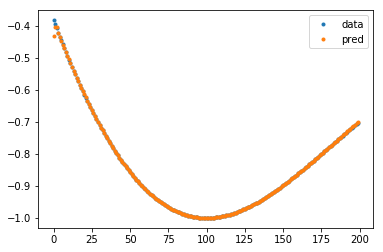

In [125]:
# Visualization
with torch.no_grad():
    
    h = 0.01;
    tt = torch.arange(-1.0, 1.0, h)  
    lentt = tt.shape[0]   
    T1 = f1(tt).view([1,lentt]).t()
    T2 = f2(tt).view([1,lentt]).t()
    T3 = f3(tt).view([1,lentt]).t()
    dataX = torch.cat((T1, T2, T3), 1)
    dataX = dataX.view(-1, dataX.shape[0], dataX.shape[1])
    T4 = f4(tt).view([1,lentt]).t()
    data = T4 
    
    # Model in evaluation state
    model.eval()      
       
    # Evalaute the model
    y_ = model(dataX)
    
    fig, ax = plt.subplots()
    ax.plot(data.numpy(),".", label="data")
    ax.plot(y_.view([lentt,1]).numpy(), ".", label="pred")
    ax.legend();